In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import sys
sys.path.append('..')
import utils
from utils import one_hot
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

/home/scrotti/Aptamer2025py/experiments/../sampling.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [3]:
experiment_id = "Dop8V930"
round_ids = ["ARN", "R01", "R02N"]
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id)
    sequences.append(s)
    print(f"Finished round {round_id}")

Finished round ARN
Finished round R01
Finished round R02N


In [242]:
seq_unique_all, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Calculating enrichments...
Finished


In [41]:
sequences_unique_all_oh = one_hot(sequences_unique_all)

## Learning

In [484]:
import importlib
importlib.reload(training)
importlib.reload(callback)
importlib.reload(data_loading)

<module 'data_loading' from '/home/scrotti/Aptamer2025py/experiments/../data_loading.py'>

In [42]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [43]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [485]:
device = torch.device('cpu')

batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [486]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [487]:
n_sweeps = 10
lr = 0.05
target_pearson = 1
max_epochs = 500

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

KeyboardInterrupt: 

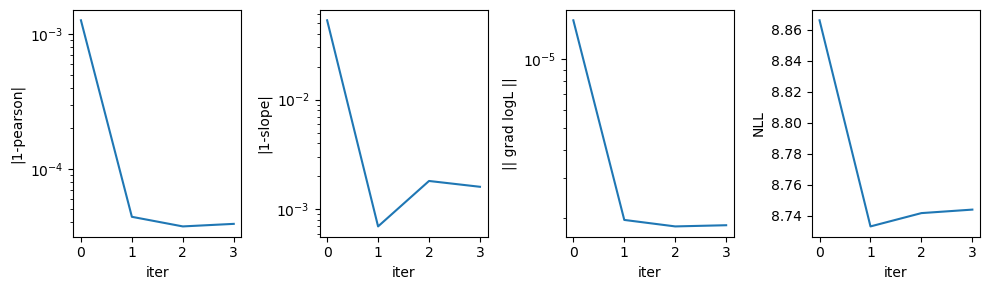

In [488]:
callbacks[0].plot();

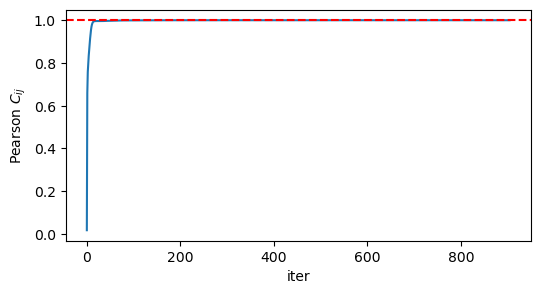

In [244]:
callbacks[1].plot();

## Group sequences by selection energy

In [ ]:
sequences_unique_all_oh, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences_oh)

Extracting unique sequences and counts at each round...


In [478]:
import importlib
importlib.reload(utils);

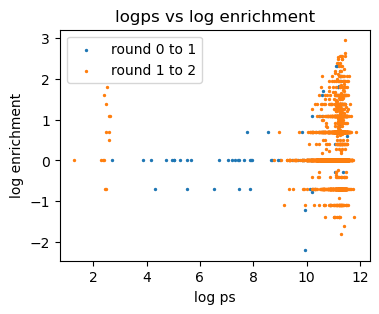

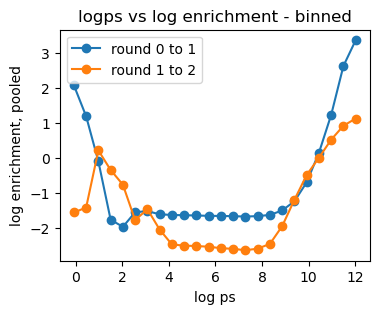

In [479]:
utils.binned_logenrichments(model, sequences_unique_all_oh, enrichments, counts_unique, 
                            n_bins = 25, plot=True, thresh=0.0, n_subsample=10**6);

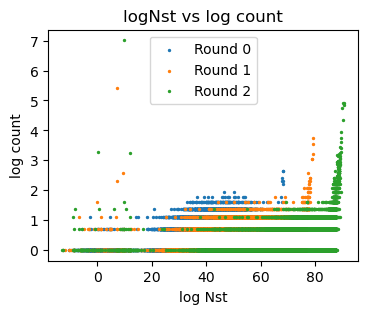

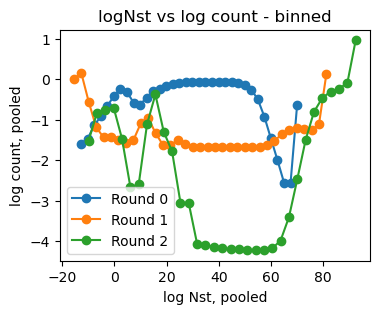

In [481]:
utils.binned_logcounts(model, sequences_unique_all_oh, counts_unique, 
                       n_bins = 35, plot=True, thresh=0.0, n_subsample=10**6);